In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import random
random.seed(42)
np.random.seed(42)

In [3]:
with open("../ressources/llm_evaluated_concat_s14-s18_2025-01-16.pickle", "rb") as file:
#with open("../ressources/llm_evaluated_concat_s14n600_s15n600_train_2024-12-12_16.pickle", "rb") as file:
#with open("../ressources/llm_evaluated_s14_n300_24-12-17.pickle", "rb") as file:
#with open("testdata.pkl", "rb") as file:
    original_df = pickle.load(file)

In [4]:
original_df["original_index"] = original_df.index

In [5]:

original_df["type"] = original_df["parameters"].map(lambda x: str(type(x.objective_params).__name__))

original_df["score_diff"] = original_df["llm_avg_score"] - original_df["avg_score"]
original_df['llm_better'] = original_df['score_diff'] > 0

original_df['llm_correct'] = original_df['score_diff'] > -original_df.groupby('type')['avg_score'].transform(lambda x: x.abs().mean()/10.0)
#original_df['llm_correct'] = original_df['score_diff'] > -original_df['avg_score'].map(lambda x: abs(x)/10.0)

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

original_df['rel_avg_score'] = original_df.groupby('type')['avg_score'].transform(minmax)
original_df['rel_llm_avg_score'] = original_df.groupby('type')['llm_avg_score'].transform(minmax)

In [6]:
# Step 1: Remove NaN and None values
df_cleaned = original_df.dropna()

# Step 2: Remove Inf values
df_cleaned = df_cleaned[~df_cleaned.isin([np.inf, -np.inf]).any(axis=1)]

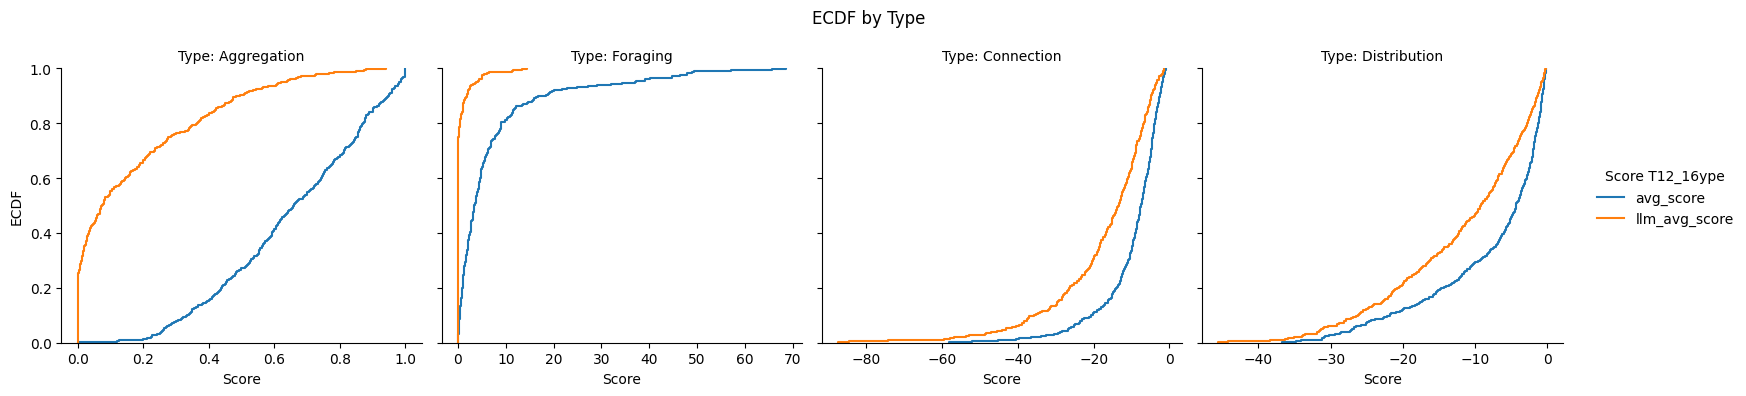

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Melt the DataFrame to long format for seaborn
df_melted = df_cleaned.melt(id_vars=['type'], value_vars=['avg_score', 'llm_avg_score'], 
                             var_name='Score Type', value_name='Score')

# Create a FacetGrid with ECDF plots
g = sns.FacetGrid(df_melted, col='type', hue='Score Type', height=4, aspect=1, sharex=False)
g.map_dataframe(sns.ecdfplot, x='Score', stat='proportion')
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Score', 'ECDF')
# Add a legend
g.add_legend(title='Score T12_16ype')

# Show the plot
g.figure.suptitle('ECDF by Type')
g.tight_layout()
plt.show()


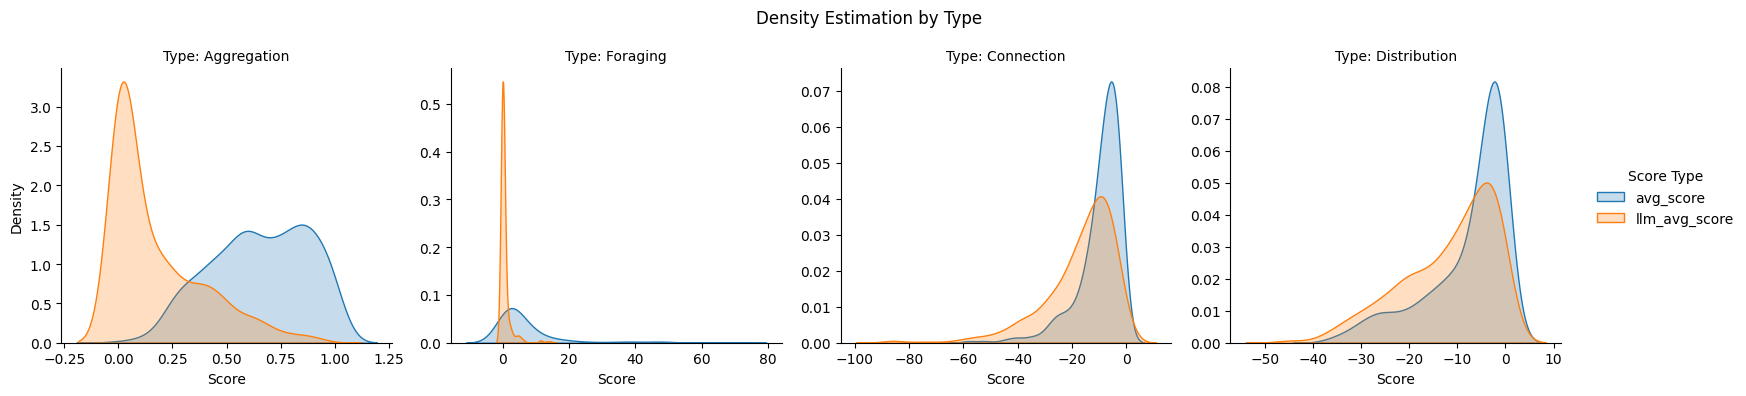

In [8]:
df_melted = df_cleaned.melt(id_vars=['type'], value_vars=['avg_score', 'llm_avg_score'], 
                             var_name='Score Type', value_name='Score')

# Create a FacetGrid with density plots
g = sns.FacetGrid(df_melted, col='type', hue='Score Type', height=4, aspect=1, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x='Score', fill=True)  # Use kdeplot for density
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Score', 'Density')


# Add a legend
g.add_legend(title='Score Type')

# Show the plot
g.figure.suptitle('Density Estimation by Type')
g.tight_layout()
plt.show()

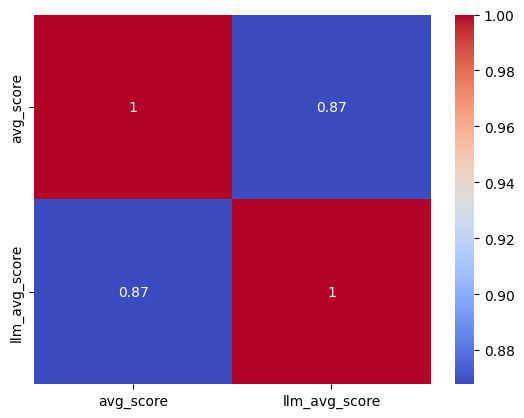

In [9]:
corrmat = df_cleaned[["avg_score","llm_avg_score"]].corr(method="spearman")

sns.heatmap(corrmat, annot=True, cmap='coolwarm')
plt.show()

/tmp/ipykernel_17754/3496947997.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_type = df.groupby('type').apply(lambda x: x[[x_key, y_key]].corr().iloc[0, 1])


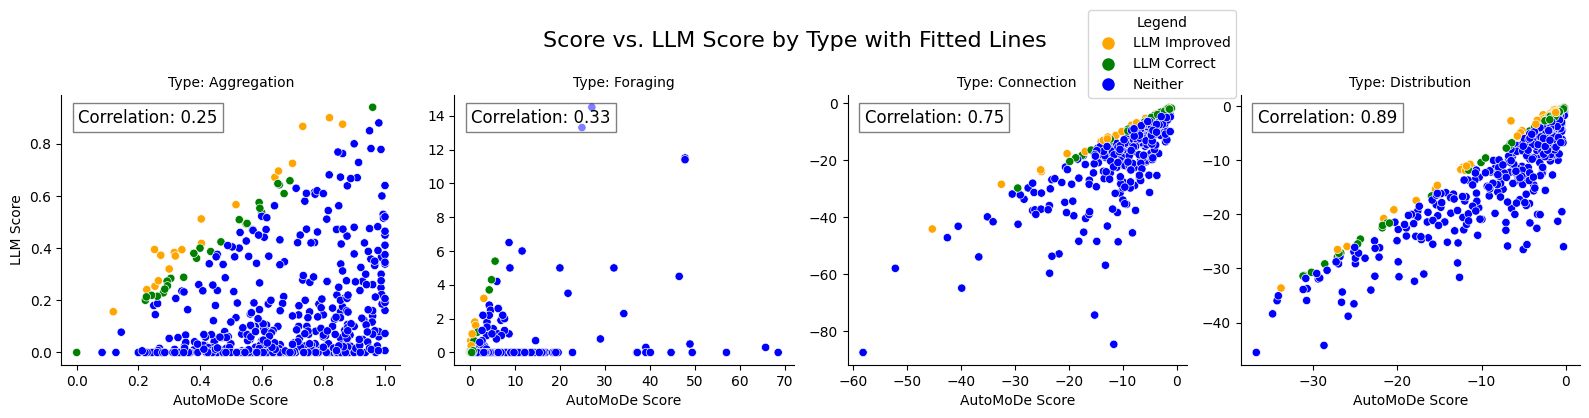

In [10]:
df = df_cleaned
type_order = list(df["type"].unique())
g = sns.FacetGrid(df, col='type', height=4, aspect=1, sharex=False, col_order=type_order, sharey=False)
x_key = "avg_score"
y_key="llm_avg_score"

# Create a new column for color based on llm_better and llm_correct
def color_condition(row):
    if row['llm_better']:
        return 'orange'  # Color for llm_better being True
    elif row['llm_correct']:
        return 'green'  # Color for llm_correct being True
    else:
        return 'blue'  # Default color

df['color'] = df.apply(color_condition, axis=1)

# Map the regression plot to the FacetGrid
g.map_dataframe(sns.scatterplot, x=x_key, y=y_key, hue='color', palette={'green': 'green', 'orange': 'orange', 'blue': 'blue'})
#g.map_dataframe(sns.regplot, x=x_key, y=y_key, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, scatter=False)

# Calculate correlation by type
correlation_by_type = df.groupby('type').apply(lambda x: x[[x_key, y_key]].corr().iloc[0, 1])

# Add correlation text to each facet in the correct order
for ax, type_name in zip(g.axes.flat, type_order):
    corr_value = correlation_by_type[type_name]
    ax.text(0.05, 0.95, f'Correlation: {corr_value:.2f}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Add titles and labels
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('AutoMoDe Score', 'LLM Score')
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Improved', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Correct', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Neither', markerfacecolor='blue', markersize=10)
]

g.fig.legend(handles=handles, loc='upper right',bbox_to_anchor=(0.78, 1.05), title='Legend')
# Show the plot
g.figure.suptitle('Score vs. LLM Score by Type with Fitted Lines', fontsize=16)
g.tight_layout()
g.fig.subplots_adjust(top=0.82)  # Adjust the title to fit
plt.show()

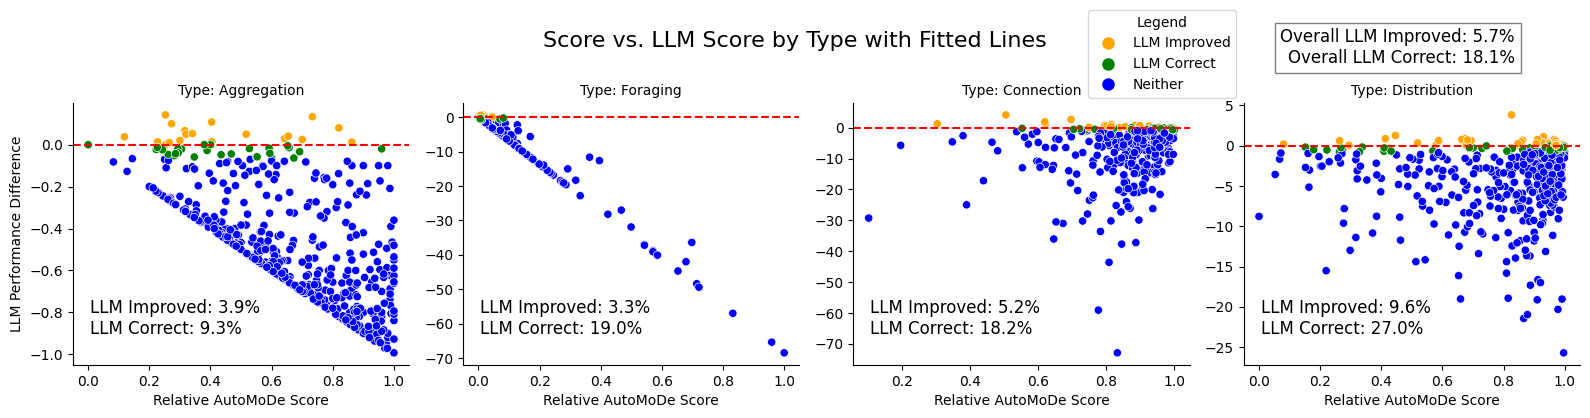

In [11]:
# Calculate the mean ratios for llm_better and llm_correct
ratios = df.groupby('type').agg(
    llm_better_mean=('llm_better', 'mean'),
    llm_correct_mean=('llm_correct', 'mean')
).reset_index()

# Convert to percentage
ratios['llm_better_ratio'] = ratios['llm_better_mean'] * 100
ratios['llm_correct_ratio'] = ratios['llm_correct_mean'] * 100

# Create the FacetGrid
type_order = list(df["type"].unique())
g = sns.FacetGrid(df, col='type', height=4, aspect=1, sharex=False, col_order=type_order, sharey=False)

# Create a new column for color based on llm_better and llm_correct
def color_condition(row):
    if row['llm_better']:
        return 'orange'  # Color for llm_better being True
    elif row['llm_correct']:
        return 'green'  # Color for llm_correct being True
    else:
        return 'blue'  # Default color

df['color'] = df.apply(color_condition, axis=1)

# Calculate total (unaggregated) ratios
total_llm_better_ratio = df['llm_better'].mean() * 100
total_llm_correct_ratio = df['llm_correct'].mean() * 100

# Map the scatter plot to the FacetGrid with color based on the new column
g.map_dataframe(sns.scatterplot, x='rel_avg_score', y='score_diff', hue='color', palette={'green': 'green', 'orange': 'orange', 'blue': 'blue'})

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(0, color='red', linestyle='--')  # Customize the color and linestyle

# Add titles and labels
g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('Relative AutoMoDe Score', 'LLM Performance Difference')

# Add the ratio text to each facet
for ax, type_name in zip(g.axes.flat, type_order):
    llm_better_value = ratios.loc[ratios['type'] == type_name, 'llm_better_ratio'].values[0]
    llm_correct_value = ratios.loc[ratios['type'] == type_name, 'llm_correct_ratio'].values[0]
    ax.text(0.05, 0.25, f'LLM Improved: {llm_better_value:.1f}%\nLLM Correct: {llm_correct_value:.1f}%', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')

g.fig.text(0.95, 0.9, f'Overall LLM Improved: {total_llm_better_ratio:.1f}%\nOverall LLM Correct: {total_llm_correct_ratio:.1f}%', 
           ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Improved', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM Correct', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Neither', markerfacecolor='blue', markersize=10)
]

g.fig.legend(handles=handles, loc='upper right',bbox_to_anchor=(0.78, 1.05), title='Legend')
# Show the plot
g.figure.suptitle('Score vs. LLM Score by Type with Fitted Lines', fontsize=16)
g.tight_layout()
g.fig.subplots_adjust(top=0.8)  # Adjust the title to fit
plt.show()

In [12]:
df.shape

(1572, 19)

In [13]:
i= 0
r = df[(df["score_diff"] > -0.2 )& (df["type"] == "Aggregation")].iloc[i][["type","avg_score", "llm_avg_score","score_diff", "llm_better", "llm_correct", "index", "original_index"]]

r




type              Aggregation
avg_score                 0.7
llm_avg_score           0.725
score_diff              0.025
llm_better               True
llm_correct              True
index                       3
original_index              3
Name: 3, dtype: object

In [14]:
original_df.iloc[r.original_index]

index                                                                3
description          The environment is constructed as a rectangula...
configuration        <?xml version="1.00" ?>\n<config>\n  <swarm-el...
parameters           MissionParams(arena_params=RectangularArena(le...
argos                <?xml version="1.00" ?>\n<argos-configuration>...
behavior_tree        --nroot 3 --nchildroot 2 --n0 0 --nchild0 2 --...
scores               [0.625, 1.0, 0.375, 0.625, 0.75, 0.75, 0.625, ...
avg_score                                                          0.7
llm_scores           [0.75, 0.875, 0.75, 0.75, 0.75, 0.375, 0.625, ...
llm_behavior_tree     --nroot 3 --nchildroot 4 --n0 0 --nchild0 2 -...
llm_avg_score                                                    0.725
original_index                                                       3
type                                                       Aggregation
score_diff                                                       0.025
llm_be

In [15]:
df.groupby('type').agg(
    llm_better_mean=('llm_better', 'mean'),
    llm_correct_mean=('llm_correct', 'mean')
).reset_index()

,type,llm_better_mean,llm_correct_mean
0,Aggregation,0.038540,0.093306
1,Connection,0.052486,0.182320
2,Distribution,0.095982,0.270089
3,Foraging,0.033457,0.189591


In [16]:
df.groupby('type').agg(
    llm_avg_score=('llm_avg_score', 'mean'),
    automode_avg_score=('avg_score', 'mean')
).reset_index()

,type,llm_avg_score,automode_avg_score
0,Aggregation,0.174278,0.652823
1,Connection,-17.239066,-9.831706
2,Distribution,-11.815967,-7.822514
3,Foraging,0.606320,7.319331


### statistical comparison wrt. hypothesis llm is at least as good as automode

In [17]:
import pandas as pd
from scipy import stats
import numpy as np

def compare_methods(df, method_col, score_col, method_A, method_B):
    # Separate scores for each method
    scores_A = df[df[method_col] == method_A][score_col]
    scores_B = df[df[method_col] == method_B][score_col]


    # Calculate means and standard deviations
    mean_A = scores_A.mean()
    mean_B = scores_B.mean()
    std_A = scores_A.std(ddof=1)  # Sample standard deviation
    std_B = scores_B.std(ddof=1)  # Sample standard deviation
    n_A = len(scores_A)
    n_B = len(scores_B)

    # Calculate pooled standard deviation
    SD_pooled = np.sqrt(((n_A - 1) * std_A**2 + (n_B - 1) * std_B**2) / (n_A + n_B - 2))

    # Calculate Cohen's d
    cohens_d = (mean_B - mean_A) / SD_pooled if SD_pooled != 0 else np.nan

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(scores_A, scores_B, alternative='greater') # greater less or two-sided
    
    # null hypothesis: method A is at most as good as method B 
    # alternative hypothesis: method A is better than method B
    stat, pval = stats.wilcoxon(scores_A, scores_B, alternative="greater") # greater d=x-y is stochastically > than distribution symmetric to zero

    # Prepare results
    results = {
        'Mean Score of A': mean_A.item(),
        'Mean Score of B': mean_B.item(),
        'Mean Difference': (mean_B - mean_A).item(),
        'T-statistic': t_stat.item(),
        'P-value': p_value.item(),
        'Cohen\'s d': cohens_d.item(),
        'Wilcoxon Statistic': stat.item(),
        'Wilvoxon P-value': pval.item()
    }

    return results


in the following we define method A as llm and method B as avg_score (automode)

In [18]:
def convert_to_comparison_df(original_df):
    # Create a new DataFrame for comparison
    comparison_data = {
        'Method': [],
        'Score': []
    }
    
    # Append Method A scores (avg_score)
    comparison_data['Method'].extend(['A'] * len(original_df))
    comparison_data['Score'].extend(original_df['llm_avg_score'].tolist())
    
    # Append Method B scores (llm_avg_score)
    comparison_data['Method'].extend(['B'] * len(original_df))
    comparison_data['Score'].extend(original_df['avg_score'].tolist())
    
    # Create a new DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df

In [19]:
convert_to_comparison_df(df)

,Method,Score
0,A,0.000000
1,A,0.000000
2,A,0.725000
3,A,-10.803506
4,A,-3.673731
...,...,...
3139,B,0.538889
3140,B,0.400000
3141,B,-1.294571
3142,B,0.692000


In [20]:
compare_methods(convert_to_comparison_df(df), 'Method', 'Score', 'A', 'B')

{'Mean Score of A': -7.178801619077608,
 'Mean Score of B': -3.0361462435941475,
 'Mean Difference': 4.142655375483461,
 'T-statistic': -10.98714573348543,
 'P-value': 1.0,
 "Cohen's d": 0.3918985097510555,
 'Wilcoxon Statistic': 25805.0,
 'Wilvoxon P-value': 1.0}

In [21]:
def apply_comparison(group):
        comparison_df = convert_to_comparison_df(group)
        return compare_methods(comparison_df, "Method", "Score", "A", "B")

    # Group by the type column and apply the comparison functionres = 
res = df.groupby("type").apply(apply_comparison)
results = {name: result for name, result in res.items()}
results

/tmp/ipykernel_17754/1273810384.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df.groupby("type").apply(apply_comparison)


{'Aggregation': {'Mean Score of A': 0.17427791807302231,
  'Mean Score of B': 0.652823366754564,
  'Mean Difference': 0.4785454486815417,
  'T-statistic': -34.31793311249838,
  'P-value': 1.0,
  "Cohen's d": 2.185811273969327,
  'Wilcoxon Statistic': 575.5,
  'Wilvoxon P-value': 1.0},
 'Connection': {'Mean Score of A': -17.239065675690608,
  'Mean Score of B': -9.831705702209943,
  'Mean Difference': 7.4073599734806646,
  'T-statistic': -8.926240753325045,
  'P-value': 1.0,
  "Cohen's d": 0.6634822499939402,
  'Wilcoxon Statistic': 918.0,
  'Wilvoxon P-value': 1.0},
 'Distribution': {'Mean Score of A': -11.815967375446428,
  'Mean Score of B': -7.8225141753125,
  'Mean Difference': 3.9934532001339287,
  'T-statistic': -6.557479043079283,
  'P-value': 0.9999999999537762,
  "Cohen's d": 0.43813999821701627,
  'Wilcoxon Statistic': 2980.0,
  'Wilvoxon P-value': 1.0},
 'Foraging': {'Mean Score of A': 0.6063197026022306,
  'Mean Score of B': 7.319330855018587,
  'Mean Difference': 6.7130111

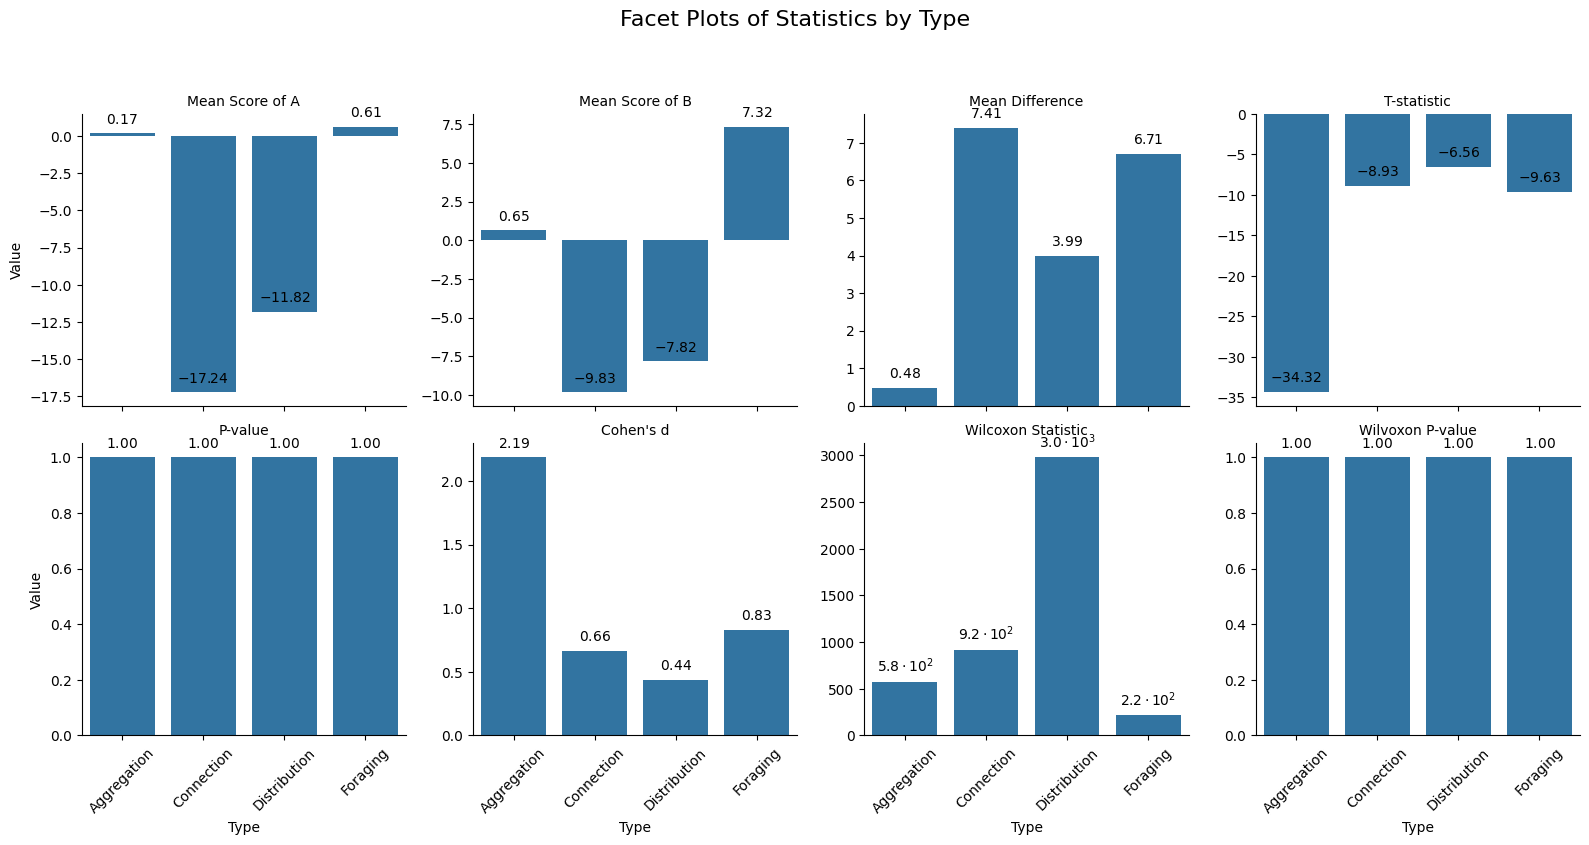

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame.from_dict({k: v for k, v in results.items()}, orient='index')

# Reset index to have 'Type' as a column
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Type'}, inplace=True)

# Melt the DataFrame for easier plotting
melted_df = results_df.melt(id_vars='Type', value_vars=['Mean Score of A', 'Mean Score of B', 'Mean Difference', 'T-statistic', 'P-value', "Cohen's d", "Wilcoxon Statistic", 'Wilvoxon P-value'],
                             var_name='Statistic', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_df, col='Statistic', col_wrap=4, height=4, sharey=False)
g.map(sns.barplot, 'Type', 'Value', order=results_df['Type'])

# Function to annotate bars with their values in LaTeX-style exponential format
def format_exponential(number):
    """Format a number in LaTeX-style exponential notation."""
    if number == 0:
        return r'$0$'
    
    # Calculate the exponent and coefficient
    exponent = int(np.floor(np.log10(abs(number))))
    coefficient = number / 10**exponent
    
    if abs(exponent) <= 1:
        return r'${:.2f}$'.format(number)
    # Format the string in LaTeX style
    formatted_string = r'${:.1f} \cdot 10^{{{}}}$'.format(coefficient, exponent)
    
    return formatted_string

def annotate_bars(ax):
    for p in ax.patches:
        height = p.get_height()

        ax.annotate(format_exponential(height),  # LaTeX-style formatting
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', 
                    fontsize=10, 
                    xytext=(0, 5),  # Offset text
                    textcoords='offset points')

# Apply the annotation function to each facet
for ax in g.axes.flatten():
    annotate_bars(ax)

# Set x-tick labels and titles
g.set_xticklabels(rotation=45)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Type", "Value")
g.fig.suptitle('Facet Plots of Statistics by Type', fontsize=16)
plt.subplots_adjust(top=0.85)  # Adjust title position

# Ensure x-tick labels correspond to actual types
for ax in g.axes.flatten():
    ax.set_xticks(range(len(results_df['Type'])))
    ax.set_xticklabels(results_df['Type'], rotation=45)

plt.show()


small p values indicate weak support for the null hypothesis so that the alternative (llms are better, here) needs to be accepted.llm_better_value
high values just mean we cannot accept the alternative hypothesis

In [23]:


format_exponential(-9.7)

'$-9.70$'